In [15]:
%load_ext autoreload
%autoreload
import os
import sys
import jax
import jax.numpy as jnp
from flax import nnx
import math

%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
    
sys.path.insert(0, os.path.abspath(os.path.join('../')))
from geometric_bayesian.models import MLP
from geometric_bayesian.operators import DenseOperator, SymOperator, PSDOperator, DiagOperator
from geometric_bayesian.densities import Normal, MultivariateNormal
from geometric_bayesian.utils import DataLoader, contour_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### PSD Operator

In [ ]:
size = 10
rng_key = jax.random.key(0)
sca = jax.random.uniform(rng_key, (1, ))
vec = jax.random.uniform(rng_key, (size, ))
mat = jax.random.uniform(rng_key, (size, size))

In [ ]:
mat += mat.transpose() + size*jnp.eye(mat.shape[0])
op = PSDOperator(
    op=mat,
    op_type='raw'
)
op_mv = PSDOperator(
    op=lambda v : jnp.matmul(mat, v),
    op_size=size
)

In [ ]:
print("dense")
print(jnp.matmul(mat,vec).tolist())
print("op chol")
print(op(vec).tolist())
print("op mv")
print(op_mv(vec).tolist())

In [ ]:
print("dense")
print(jnp.linalg.solve(mat, vec).tolist())
print("op chol")
print(op.solve(vec).tolist())
print("op mv")
print(op_mv.solve(vec).tolist())

In [ ]:
print("dense")
print(jnp.linalg.eigh(mat)[0].tolist())
print("op chol")
print(op.diagonalize(num_iterations=10, rng_key=rng_key).tolist())
print("op mv")
print(op_mv.diagonalize(num_iterations=10, rng_key=rng_key).tolist())

### Normal

In [ ]:
mean = jnp.array(1.0)
cov = jnp.array(1.0)
pdf = Normal(mean, cov)
x = jnp.linspace(-2, 4, 100)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x, pdf(x))

### Multivariate Normal

In [ ]:
mean = jnp.array([0.0, 0.0])
# cov = jnp.array([1.0, 0.5])
s, u = jnp.diag(jnp.array([1.0, 0.5])), jnp.array([[1.0, 1.0],[-1.0,1.0]])
cov = PSDOperator(
    op=jnp.matmul(u.transpose(), jnp.matmul(s,u)),
    op_type='raw'
)
pdf = MultivariateNormal(mean, cov)

In [ ]:
_ = contour_plot(pdf)

### GGN

In [2]:
model = MLP(
    layers=[3, 64, 2],
    rngs=nnx.Rngs(params=0),
    prob_out=False,
)

In [3]:
rng_key = jax.random.key(0)
train_samples = jax.random.uniform(rng_key, (10, model.shape[0]))
train_targets = jax.random.uniform(rng_key, (10, model.shape[1]))

graph_def, params = nnx.split(model)
num_params = sum(x.size for x in jax.tree.leaves(params))

In [4]:
from geometric_bayesian.curv.ggn import ggn
ggn_mv = ggn(
    p = lambda f: MultivariateNormal(f, DiagOperator(jnp.array(1.0), model.shape[1])),
    f = model,
    X = train_samples,
    y = train_targets,
)

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join('/home/bernardo/repos/laplax/')))
from laplax.curv import create_ggn_mv
from laplax.util.loader import input_target_split

def model_fn(input,params):
    return nnx.call((graph_def, params))(input)[0]
    
ggn_mv_test = create_ggn_mv(
    model_fn,
    params,
    {
        'input': train_samples,
        'target': train_targets
    },
    loss_fn="mse",
    num_curv_samples=train_samples.shape[0],
    num_total_samples=train_samples.shape[0] // 2,
)

In [6]:
ggn_mv(params, params)

State({
  'layers': {
    0: {
      'bias': VariableState( # 64 (256 B)
        type=Param,
        value=Array([ 0.83594525, -0.5164942 ,  0.03436323, -0.690176  , -1.0129764 ,
                2.0173502 , -0.32922047,  0.88988614, -0.86550665,  0.04127937,
               -0.5553422 ,  0.3108242 ,  1.7424173 ,  1.9458587 , -1.302687  ,
               -0.4317423 , -0.72082144,  1.0590292 ,  0.5459955 , -0.39184502,
               -1.2446938 ,  0.8741347 ,  1.203608  , -0.33772844,  0.15795767,
                0.25572067,  1.0938712 ,  0.41659057, -0.24840105,  0.10417532,
                0.06286832,  0.01155724, -1.1849874 ,  0.26037198,  2.3539422 ,
                0.3383573 ,  0.13301492, -1.7348627 , -0.71643186,  0.5440028 ,
                0.35448498,  0.8737606 , -0.19707195,  2.173308  ,  0.9971881 ,
               -0.8570071 , -1.3360002 ,  0.30731797, -1.6850624 ,  0.5823547 ,
                0.12258084,  0.7222438 , -0.18737113,  0.81835437,  0.09960343,
               -0.521

In [7]:
ggn_mv_test(params)

State({
  'layers': {
    0: {
      'bias': VariableState( # 64 (256 B)
        type=Param,
        value=Array([ 0.83594525, -0.5164942 ,  0.03436323, -0.690176  , -1.0129764 ,
                2.0173502 , -0.32922047,  0.88988614, -0.86550665,  0.04127937,
               -0.5553422 ,  0.3108242 ,  1.7424173 ,  1.9458587 , -1.302687  ,
               -0.4317423 , -0.72082144,  1.0590292 ,  0.5459955 , -0.39184502,
               -1.2446938 ,  0.8741347 ,  1.203608  , -0.33772844,  0.15795767,
                0.25572067,  1.0938712 ,  0.41659057, -0.24840105,  0.10417532,
                0.06286832,  0.01155724, -1.1849874 ,  0.26037198,  2.3539422 ,
                0.3383573 ,  0.13301492, -1.7348627 , -0.71643186,  0.5440028 ,
                0.35448498,  0.8737606 , -0.19707195,  2.173308  ,  0.9971881 ,
               -0.8570071 , -1.3360002 ,  0.30731797, -1.6850624 ,  0.5823547 ,
                0.12258084,  0.7222438 , -0.18737113,  0.81835437,  0.09960343,
               -0.521

In [14]:
from geometric_bayesian.utils.helper import wrap_pytree_function, pytree_to_array
ggn_mv = wrap_pytree_function(ggn_mv, params)
vec_params = pytree_to_array(params)
jax.vmap(ggn_mv, in_axes=(None,0))(vec_params,jnp.eye(num_params))

NameError: name 'ggn_mv' is not defined

In [11]:
from laplax.curv.cov import create_posterior_fn, create_full_curvature
from laplax.util.flatten import (
    create_pytree_flattener,
    wrap_factory,
    wrap_function,
)
from laplax.util.mv import diagonal, to_dense
from laplax.util.tree import get_size, eye_like

flatten, unflatten = create_pytree_flattener(params)
mv_wrapped = wrap_function(ggn_mv_test, input_fn=unflatten, output_fn=flatten)
to_dense(mv_wrapped, layout=get_size(params))

Array([[ 0.22213522, -0.09057042,  0.04878144, ...,  0.08164886,
         0.252145  ,  0.26260477],
       [-0.09057042,  0.04564524, -0.01608627, ..., -0.07747103,
        -0.06939048, -0.12981851],
       [ 0.04878145, -0.01608627,  0.02457506, ...,  0.00399241,
         0.1512383 ,  0.00751573],
       ...,
       [ 0.08164886, -0.07747103,  0.00399241, ...,  0.63480586,
         0.        ,  0.4586725 ],
       [ 0.252145  , -0.06939047,  0.1512383 , ...,  0.        ,
         1.4803627 ,  0.        ],
       [ 0.26260477, -0.1298185 ,  0.00751573, ...,  0.4586725 ,
         0.        ,  1.4803627 ]], dtype=float32)

### Embedded Geometry

In [2]:
def sphere_embedding(x, r=1.0):
    return r*jnp.array([jnp.sin(x[0])*jnp.cos(x[1]), jnp.sin(x[0])*jnp.sin(x[1]), jnp.cos(x[0])])

def surf_embedding(x):
    return jnp.array([x[0], x[1], x[0]**2 + x[1]**2])

def sphere_metric(x,r=1.0):
    return jnp.array([[1.0, 0.0],[0.0, jnp.sin(x[0])**2]])*r**2

In [3]:
x = jnp.array([0.5,0.2])
vi = jnp.array([0.1,0.3])
vj = jnp.array([0.1,0.3]) # jnp.array([0.5,0.7])
embedding = sphere_embedding
metric = sphere_metric

In [31]:
from geometric_bayesian.utils.math import pullback
from geometric_bayesian.operators import DiagOperator

H = DiagOperator(jnp.array(2.0), 2)
print('Reference', metric(x))
print('Identity pullback', jax.lax.map(lambda v: pullback(embedding)(x,v), jnp.eye(2)))
print('Non-identity pullback', jax.lax.map(lambda v: pullback(embedding, H)(x,v), jnp.eye(2)))

Reference [[1.         0.        ]
 [0.         0.22984886]]
Identity pullback [[ 1.0000000e+00  2.4733344e-09]
 [-7.2299144e-10  2.2984886e-01]]
Non-identity pullback [[ 2.0000000e+00  4.9466689e-09]
 [-1.4459829e-09  4.5969772e-01]]


In [39]:
from geometric_bayesian.geom.embedding import pullmetric, christoffel_fk, christoffel_sk
print('Reference', metric(x))
print('Identity pullback', jax.lax.map(lambda v: pullmetric(embedding)(x,v), jnp.eye(2)))
print('Metric-Vector product', pullmetric(embedding)(x,vi))
print('C1k-Vector product', christoffel_fk(embedding)(x,vi))
print('C2k-Vector product', christoffel_sk(embedding)(x,vi))

Reference [[1.         0.        ]
 [0.         0.22984886]]
Identity pullback [[ 1.0000000e+00  2.4733344e-09]
 [-7.2299144e-10  2.2984886e-01]]
Metric-Vector product [0.10000001 0.06895467]
C1k-Vector product [-0.0378662   0.02524413]
C2k-Vector product [-0.03786619  0.10982927]


In [44]:
from geometric_bayesian.utils.math import hvp, hvp_2
print('Hessian-Vector product', hvp(embedding)(x,vi))
print('Hessian-Vector product', hvp_2(embedding)(x,vi))

Hessian-Vector product (Array([[-0.09929152, -0.15839557],
       [ 0.2485021 ,  0.05743479],
       [-0.08775826,  0.        ]], dtype=float32),)
Hessian-Vector product [[-0.09929152 -0.15839557]
 [ 0.2485021   0.05743479]
 [-0.08775826  0.        ]]


In [45]:
g = pullmetric(embedding)
g_fn = lambda x: jax.lax.map(lambda v: g(x,v), jnp.eye(2))
# jax.vjp(g_fn, x)[1](jnp.vstack([vi,vi]).T)
# vi@jax.jvp(g_fn, (x,), (vi,))[1]
print("First term Christoffel", jnp.einsum('mji,i->mj', jax.jacfwd(g_fn)(x), vi)@vj)
print("Second term Christoffel", jnp.einsum('mij,i->mj', jax.jacfwd(g_fn)(x), vi)@vj)
print("Third term Christoffel", jnp.einsum('ijm,i->mj', jax.jacfwd(g_fn)(x), vi)@vj)

First term Christoffel [0.         0.02524413]
Second term Christoffel [0.         0.02524413]
Third term Christoffel [7.5732395e-02 6.7055228e-10]


In [51]:
jvp = lambda x: jax.linearize(sphere_embedding, x)[1]
vjp = lambda x: jax.linear_transpose(jvp(x), vj)
grad = lambda x: jax.lax.map(vjp(x), jnp.eye(3))
hess = lambda v: jax.jvp(grad, (x,), (v,))[1][0]

print("Hessian SC", jvp(x)(vj)@hess(vi), "Hessian DC", vjp(x)(hess(vi)@vj)[0])
print("First term Christoffel", jvp(x)(vj)@hess(vi) + vjp(x)(hess(vi)@vj)[0])

print("Hessian SC", jvp(x)(vi)@hess(vj), "Hessian DC", vjp(x)(hess(vj)@vi)[0])
print("Second term Christoffel", jvp(x)(vi)@hess(vj) + vjp(x)(hess(vj)@vi)[0])

print("Hessian SC", jvp(x)(vj)@hess(vi), "Hessian SC", jvp(x)(vi)@hess(vj))
print("Third term Christoffel", jvp(x)(vj)@hess(vi) + jvp(x)(vi)@hess(vj))

Hessian SC [ 3.7866201e-02 -4.1039028e-10] Hessian DC [-0.0378662   0.02524413]
First term Christoffel [3.7252903e-09 2.5244134e-02]
Hessian SC [ 3.7866201e-02 -4.1039028e-10] Hessian DC [-0.0378662   0.02524413]
Second term Christoffel [3.7252903e-09 2.5244134e-02]
Hessian SC [ 3.7866201e-02 -4.1039028e-10] Hessian SC [ 3.7866201e-02 -4.1039028e-10]
Third term Christoffel [ 7.5732403e-02 -8.2078055e-10]


### Geodesic Integration (Embedding)

In [10]:
import time
from functools import partial
from geometric_bayesian.geom.embedding import pullmetric, christoffel_fk, christoffel_sk

def torus(x, a=3.0, b=1.0):
    return jnp.array([(a+b*jnp.cos(x[1])) * jnp.cos(x[0]), (a+b*jnp.cos(x[1])) * jnp.sin(x[0]), b*jnp.sin(x[1])])
csk = christoffel_sk(torus)

@jax.jit
def dynamics(x,v):
    return -csk(x,v)

def ode_ef(f,x0,v0,dt,T):
    steps = int(T/dt)
    x, v = jnp.zeros((steps,len(x0))), jnp.zeros((steps, len(v0)))
    x, v = x.at[0].set(x0), v.at[0].set(v0)
    for i in range(steps-1):
        v = v.at[i+1].set(v[i] + dt*f(x[i], v[i]))
        x = x.at[i+1].set(x[i] + dt*v[i+1])
    return x, v

In [11]:
rot = jnp.linspace(0, 2*jnp.pi, 9)[:-1]
x0 = jnp.array([[jnp.pi, jnp.pi]]).repeat(rot.shape[0],axis=0)
v0 = jnp.vstack((jnp.cos(rot),jnp.sin(rot))).transpose()
dt, T = 0.01, 2.5

start = time.time()
x,v = jax.vmap(lambda x,v: ode_ef(dynamics, x, v, dt=dt, T=T), in_axes=(0,0))(x0,v0)
print(time.time() - start)

4.181568622589111


In [12]:
def euler_forward(f, x, v, dt):
    vn = v + dt*f(x, v)
    xn = x + dt*v
    return xn, vn

def step(carry,_):
    x,v = euler_forward(f=dynamics, x=carry[0], v=carry[1], dt=0.01)
    return (x,v), (x,v)

start = time.time()
trajectory = jax.vmap(lambda x,v: jax.lax.scan(step, (x, v), None, length=int(T/dt))[1], in_axes=(0,0))(x0,v0)
print(time.time() - start)

0.6996493339538574


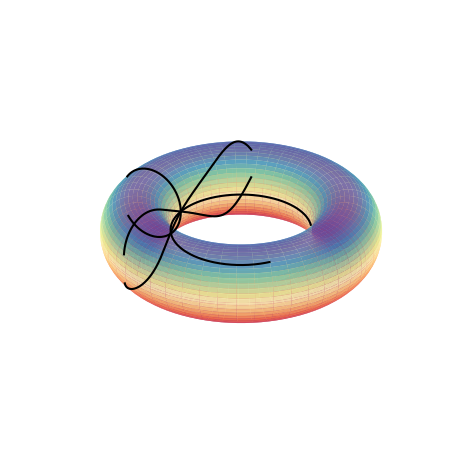

In [13]:
from geometric_bayesian.utils.plot import surf_plot
fig = surf_plot(jax.vmap(torus,0), min=[0.0,0.0], max=[2*jnp.pi,2*jnp.pi], res=100)
ax = fig.axes[0]
for i in range(rot.shape[0]):
    traj = jax.lax.map(torus, trajectory[0][i])
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color="k")

### Geodesic Integration (Metric)

In [16]:
import time
from geometric_bayesian.geom.embedding import pullmetric
from geometric_bayesian.geom.metric import christoffel_fk,christoffel_sk
def torus(x, a=3.0, b=1.0):
    return jnp.array([(a+b*jnp.cos(x[1])) * jnp.cos(x[0]), (a+b*jnp.cos(x[1])) * jnp.sin(x[0]), b*jnp.sin(x[1])])

g_torus = pullmetric(torus)
csk = christoffel_sk(g_torus)

@jax.jit
def dynamics(x,v):
    return -csk(x,v)

In [17]:
from geometric_bayesian.integrate.integrate import integrate
from geometric_bayesian.integrate.euler_forward import euler_forward

rot = jnp.linspace(0, 2*jnp.pi, 9)[:-1]
x0 = jnp.array([[jnp.pi, jnp.pi]]).repeat(rot.shape[0],axis=0)
v0 = jnp.vstack((jnp.cos(rot),jnp.sin(rot))).transpose()
dt, T = 0.01, 2.5
step = integrate(
    f = dynamics,
    dt = dt,
    T = T,
    integrator = euler_forward,
)

In [18]:
start = time.time()
trajectory = jax.vmap(step, in_axes=(0,0))(x0,v0)
print(time.time() - start)

1.9482717514038086


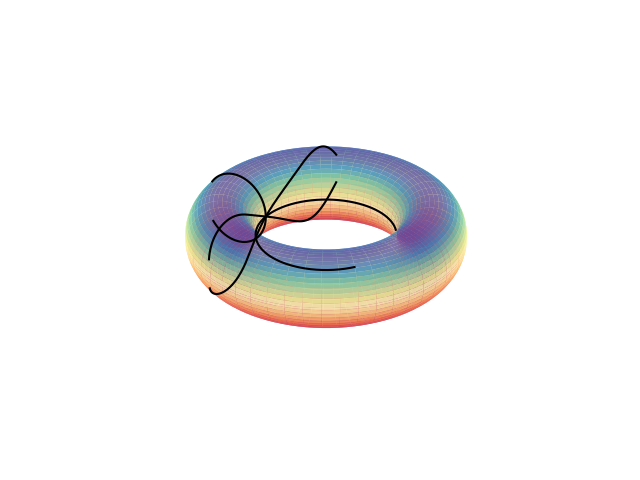

In [19]:
from geometric_bayesian.utils.plot import surf_plot
fig = surf_plot(jax.vmap(torus,0), min=[0.0,0.0], max=[2*jnp.pi,2*jnp.pi], res=100)
ax = fig.axes[0]
for i in range(rot.shape[0]):
    traj = jax.lax.map(torus, trajectory[0][i])
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color="k")

### Custom derivatives

In [ ]:
@jax.custom_vjp
def myfun(x):
    return x[0]**2 + 5*x[1]**3 + x[0]*x[1]
def grad_myfun(x):
    return jnp.array([2*x[0] + x[1], 15*x[1]**2 + x[0]])
def hess_myfun(x):
    return jnp.array([[2, 1],[1,30*x[1]]])

In [ ]:
def myfun_fwd(x):
  # Returns primal output and residuals to be used in backward pass by f_bwd.
  return myfun(x), ([2*x[0] + x[1], 15*x[1]**2 + x[0]])

def myfun_bwd(res, g):
  arg_1, arg_2 = res # Gets residuals computed in f_fwd
  return (jnp.array([arg_1 * g, arg_2 * g]),)

myfun.defvjp(myfun_fwd, myfun_bwd)

In [ ]:
x = jnp.array([0.2, 0.5])
v = jnp.array([0.3, 0.3])
print(grad_myfun(x))
print(jax.grad(myfun)(x))

In [ ]:
from functools import partial

p = lambda f: MultivariateNormal(f, cov=DiagOperator(1.0, model.shape[1]))

@partial(jax.custom_jvp, nondiff_argnums=(0,1))
def neg_logll(p, y, f):
    return jax.vmap(lambda y, f: -p(f)._logpdf(y), in_axes=(0,0))(y, f).sum()

def neg_logll_autograd(p, y, f):
    return jax.vmap(lambda y, f: -p(f)._logpdf(y), in_axes=(0,0))(y, f).sum()

@partial(jax.custom_jvp, nondiff_argnums=(0,1,3))
@neg_logll.defjvp
def neg_logll_jvp(p, y, primals, tangents):
    print("hello")
    f = primals[0]
    v = tangents[0]
    out = jax.vmap(lambda y, f, v: -p(f)._logpdf_jvp_mean(y, v), in_axes=(0,0,0))(y, f, v).sum(axis=0)
    return jax.ShapeDtypeStruct(out.shape, out.dtype), out

@neg_logll_jvp.defjvp
def neg_logll_hvp(p, y, dummy_tangents, primals_new, tangents_new):
    print("hello2")
    f = primals_new[0]
    v = tangents_new[0]
    out = jax.vmap(lambda y, f, v: -p(f)._logpdf_hvp_mean(y, v), in_axes=(0,0,0))(y, f, v).sum(axis=0)
    return jax.ShapeDtypeStruct(out.shape, out.dtype), out

In [ ]:
v = jax.random.uniform(rng_key, (10, model.shape[1]))

In [ ]:
neg_logll_jvp(p, train_targets, (model(train_samples),), (v,))[1]

In [ ]:
jax.jvp(lambda f: neg_logll(p, train_targets, f), (model(train_samples),), (v,))[1]

In [ ]:
jax.jvp(lambda f: neg_logll_autograd(p, train_targets, f), (model(train_samples),), (v,))[1]

In [ ]:
neg_logll_hvp(p, train_targets, None, (model(train_samples),), (v,))[1]

In [ ]:
jax.jvp(lambda f: neg_logll_jvp(p, train_targets, f, None), (model(train_samples),), (v,) )[1]

In [ ]:
jax.jvp(jax.grad(f), primals, tangents)[1]

In [ ]:
jax.jvp(jax.grad(lambda f: neg_logll(p, train_targets, f)), (model(train_samples),),(v,))[1]

In [ ]:
(lambda f: neg_logll_autograd(p, train_targets, f(train_samples)))(model)